### Building a 3D dataset

In [25]:
import numpy as np
np.random.seed(4)
w1, w2 =0.1,0.3
noise=0.1
m =60

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m,3))
X[:,0] = np.cos(angles) + np.sin(angles)/2 +noise * np.random.randn(m)/2
X[:,1] = np.sin(angles) * 0.7 + noise * np.random.randn(m)/2
X[:,2] = X[:,0] * w1 +X[:,1] * w2 + noise * np.random.randn(m)


### PCA using SVD decomposition

In [26]:
# dont't understand this much

X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:,0]
c2 = Vt.T[:,1]


In [27]:
print(s)
print(Vt)
print(c2)

[6.77645005 2.82403671 0.78116597]
[[ 0.93636116  0.29854881  0.18465208]
 [-0.34027485  0.90119108  0.2684542 ]
 [-0.08626012 -0.31420255  0.94542898]]
[-0.34027485  0.90119108  0.2684542 ]


In [28]:
print(X_centered.shape)
print(X.shape)

(60, 3)
(60, 3)


In [29]:
m, n = X.shape
S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [30]:
np.allclose(X_centered, U.dot(S).dot(Vt))

# to find if two arrays are equivalent 
# within a tolerance

True

In [31]:
W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2)

In [32]:
X2D_using_svd = X2D

In [33]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

### PCA using Scikit learn

In [34]:
from sklearn .decomposition import PCA

pca = PCA(n_components =2)
X2D = pca.fit_transform(X)

X2D[:5]

# axis are flipped here
# between X2D and X2D_svd

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [35]:
np.allclose(X2D, -X2D_using_svd)

True

In [36]:
# we can recover 3D points project through
# inverse_transform

X3D_inv = pca.inverse_transform(X2D)

In [37]:
# there is some loss of information however

np.allclose(X3D_inv,X)

False

In [38]:
# computing the reconstruction error

np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

In [41]:
# inverse transform of SVD looks like this

X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

In [42]:
# PCA class automatically takes care of reversing the mean but if we
# subtract the mean  we get the same

np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

In [44]:
#pca componenet

pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [45]:
# pca in svd 

Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

In [46]:
pca.explained_variance_ratio_

# first dimesnion explains 84.2 percentof the variance while the second
# explains 14.6 percent

array([0.84248607, 0.14631839])

In [47]:
1 - pca.explained_variance_ratio_.sum()

# by projecting to 2D we loose about 1.1 percent of the variance

0.011195535570688975

In [48]:
# we can compute the explained variance ratio using the SVD approach
# s is the diagnol of the matrix S

np.square(s)/ np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

### Drawing figures

In [57]:
# utility for arrow function

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0),*args, **kwargs )
        self._verts3d = xs, ys, zs
        
    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d. proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [53]:
# expressing the plane as a function of x and y
import matplotlib.pyplot as plt

axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0,2] * x1 + R[1,2] * x2) / (1 - R[2,2])

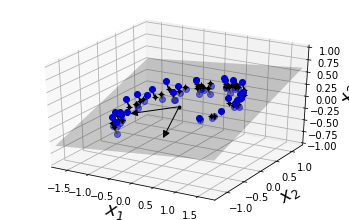

In [58]:
# plotting the 3D dataset the plane and the projections on that plane

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:,2] > X3D_inv[:,2]]
X3D_below = X[X[:,2] <= X3D_inv[:,2]]

ax.plot(X3D_below[:,0], X3D_below[:,1], X3D_below[:,2],"bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(X, axis=0)
ax.add_artist(Arrow3D([0,C[0,0]], [0,C[0,1]],[0,C[0,2]], mutation_scale=15, lw =1, arrowstyle="-|>", color="k" ))
ax.add_artist(Arrow3D([0,C[1,0]], [0,C[1,1]],[0,C[1,2]], mutation_scale=15, lw=1, arrowstyle="-|>",color="k"))
ax.plot([0], [0], [0],"k.")

for i in range(m):
    if X[i,2] > X3D_inv[i,2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else :
        ax.plot([X[i][0], X3D_inv[i][0]],[X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050" )

ax.plot(X3D_inv[:,0], X3D_inv[:,1], X3D_inv[:,2], "k+")
ax.plot(X3D_inv[:,0], X3D_inv[:,1], X3D_inv[:,2], "k.")
ax.plot(X3D_above[:,0], X3D_above[:,1], X3D_above[:,2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()


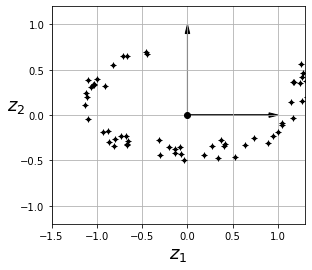

In [59]:
# plotting it on a flat projection

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:,0], X2D[:,1], "k+")
ax.plot(X2D[:,0], X2D[:,1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0,0,0,1,head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k' )
ax.arrow(0,0,1,0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5,1.3,-1.2,1.2])
ax.grid(True)
plt.show()